# Calculate U,V from SLP

We'll calculate
$$\vec{U} = \frac{1}{\rho\,f} \hat{k} \times \nabla P$$
with $P$ being sea-level pressure (SLP) and compare to the near-surface velocities.

In [1]:
import xarray as xr
from datetime import datetime, timedelta
from dask.distributed import Client

In [2]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit=500e6)
client

<Client: 'tcp://127.0.0.1:36893' processes=4 threads=4, memory=2.00 GB>

In [3]:
def get_latest_forecast_url(
    url=(
        "https://thredds-jumbo.unidata.ucar.edu/thredds/"
        "dodsC/grib/NCEP/GFS/Global_onedeg/"
        "GFS_Global_onedeg_{time_stamp}.grib2"
        )
):
    """Find the latest GFS forecast dataset."""
    now = datetime.now()
    today = datetime(now.year, now.month, now.day)
    tomorrow = today + timedelta(days=1)
    for nback in range(8):
        try_date = tomorrow - nback * timedelta(hours=6)
        try_time_stamp = try_date.strftime("%Y%m%d_%H%M")
        try_url = url.format(time_stamp=try_time_stamp)
        try:
            ds = xr.open_dataset(try_url)
            return try_url
        except OSError as e:
            pass
    raise ValueError("Didn't find any working forecast url.")

In [4]:
latest_forecast_url = get_latest_forecast_url()
print(f"Using: {latest_forecast_url}")

Using: https://thredds-jumbo.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_onedeg/GFS_Global_onedeg_20200805_0600.grib2


In [5]:
full_ds = xr.open_dataset(
    latest_forecast_url,
    chunks={}
)
full_ds

<xarray.Dataset>
Dimensions:                                                                     (altitude_above_msl: 3, altitude_above_msl1: 1, depth_below_surface_layer: 4, depth_below_surface_layer_bounds_1: 2, height_above_ground: 1, height_above_ground1: 2, height_above_ground2: 3, height_above_ground3: 1, height_above_ground4: 7, height_above_ground_layer: 1, height_above_ground_layer1: 1, height_above_ground_layer1_bounds_1: 2, height_above_ground_layer_bounds_1: 2, hybrid: 1, isobaric: 31, isobaric1: 29, isobaric2: 19, isobaric3: 1, isobaric4: 21, isobaric5: 24, isobaric6: 34, isobaric7: 22, lat: 181, lon: 360, potential_vorticity_surface: 2, pressure_difference_layer: 1, pressure_difference_layer1: 2, pressure_difference_layer1_bounds_1: 2, pressure_difference_layer2: 1, pressure_difference_layer2_bounds_1: 2, pressure_difference_layer_bounds_1: 2, sigma: 1, sigma_layer: 4, sigma_layer_bounds_1: 2, time: 128, time1: 129, time2: 128, time2_bounds_1: 2, time3: 254, time3_bounds_1: 2)
Coordinates:
  * lat                                                                         (lat) float32 90.0 ... -90.0
  * lon                                                                         (lon) float32 0.0 ... 359.0
    reftime                                                                     datetime64[ns] ...
  * time                                                                        (time) datetime64[ns] 2020-08-05T09:00:00 ... 2020-08-21T06:00:00
  * time1                                                                       (time1) datetime64[ns] 2020-08-05T06:00:00 ... 2020-08-21T06:00:00
  * time2                                                                       (time2) datetime64[ns] 2020-08-05T09:00:00 ... 2020-08-21T06:00:00
  * time3                                                                       (time3) datetime64[ns] 2020-08-05T09:00:00 ... 2020-08-21T06:00:00
  * isobaric                                                                    (isobaric) float32 100.0 ... 100000.0
  * height_above_ground                                                         (height_above_ground) float32 2.0
  * sigma                                                                       (sigma) float32 0.995
  * isobaric1                                                                   (isobaric1) float32 40.0 ... 100000.0
  * isobaric2                                                                   (isobaric2) float32 10000.0 ... 100000.0
  * isobaric3                                                                   (isobaric3) float32 50000.0
  * height_above_ground1                                                        (height_above_ground1) float32 2.0 80.0
  * isobaric4                                                                   (isobaric4) float32 10000.0 ... 100000.0
  * altitude_above_msl                                                          (altitude_above_msl) float32 1829.0 ... 3658.0
  * pressure_difference_layer                                                   (pressure_difference_layer) float32 12750.0
  * pressure_difference_layer1                                                  (pressure_difference_layer1) float32 9000.0 12750.0
  * sigma_layer                                                                 (sigma_layer) float32 0.58000004 ... 0.83000004
  * height_above_ground2                                                        (height_above_ground2) float32 2.0 ... 100.0
  * isobaric5                                                                   (isobaric5) float32 40.0 ... 100000.0
  * potential_vorticity_surface                                                 (potential_vorticity_surface) float32 -2e-06 2e-06
  * height_above_ground_layer                                                   (height_above_ground_layer) float32 1500.0
  * depth_below_surface_layer                                                   (depth_below_surface_layer) float32 0.05 ... 1.5
  * pressure_differ

In [6]:
def extract_gfs_field(ds, varname):
    """Extract var and clean up labels."""
    
    # extract var
    var = ds[varname]
    
    # drop digits in dim names (time1-->time, etc.)
    var = var.rename({d: d[:-1] for d in var.dims if d[-1].isdigit()})
    
    # drop singleton coords
    var = var.drop((c for c in var.coords if var.coords[c].shape == ()))
    
    return var

In [7]:
P = extract_gfs_field(full_ds, "Pressure_surface").rename("P")
P

<xarray.DataArray 'P' (time: 129, lat: 181, lon: 360)>
dask.array<open_dataset-96b85b424498bb224e5325b9d5bef98bPressure_surface, shape=(129, 181, 360), dtype=float32, chunksize=(129, 181, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 2020-08-05T06:00:00 ... 2020-08-21T06:00:00
Attributes:
    long_name:                      Pressure @ Ground or water surface
    units:                          Pa
    abbreviation:                   PRES
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-3-0_L1
    Grib2_Parameter:                [0 3 0]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Mass
    Grib2_Parameter_Name:           Pressure
    Grib2_Level_Type:               1
    Grib2_Level_Desc:               Ground or water surface
    Grib2_Generating_Process_Type:  Forecast

In [8]:
ocean = (
    extract_gfs_field(full_ds, "Land_cover_0__sea_1__land_surface") == 0
).isel(time=0, drop=True).rename("oean")
ocean

<xarray.DataArray 'oean' (lat: 181, lon: 360)>
dask.array<getitem, shape=(181, 360), dtype=bool, chunksize=(181, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0

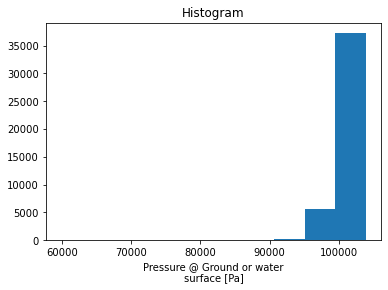

In [9]:
P.where(ocean).isel(time=0).plot.hist();

In [10]:
%time P = P.where(ocean).compute()

CPU times: user 1.66 s, sys: 1.16 s, total: 2.83 s
Wall time: 26.6 s


## Generate XGCM grid

In [11]:
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

In [12]:
ds_g = generate_grid_ds(
    P.to_dataset(),
    axes_dims_dict={'Y': 'lat', 'X':'lon'},
    position={
        "X": ("center", "right"),
        "Y": ("center", "right")
    }
)
ds_g

<xarray.Dataset>
Dimensions:    (lat: 181, lat_right: 181, lon: 360, lon_right: 360, time: 129)
Coordinates:
  * lat        (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time       (time) datetime64[ns] 2020-08-05T06:00:00 ... 2020-08-21T06:00:00
  * lat_right  (lat_right) float32 89.5 88.5 87.5 86.5 ... -88.5 -89.5 -90.5
  * lon_right  (lon_right) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables:
    P          (time, lat, lon) float32 101074.15 101074.15 ... nan nan

In [13]:
ds_g.attrs["grid"] = Grid(ds_g)
ds_g

<xarray.Dataset>
Dimensions:    (lat: 181, lat_right: 181, lon: 360, lon_right: 360, time: 129)
Coordinates:
  * lat        (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time       (time) datetime64[ns] 2020-08-05T06:00:00 ... 2020-08-21T06:00:00
  * lat_right  (lat_right) float32 89.5 88.5 87.5 86.5 ... -88.5 -89.5 -90.5
  * lon_right  (lon_right) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables:
    P          (time, lat, lon) float32 101074.15 101074.15 ... nan nan
Attributes:
    grid:     <xgcm.Grid>\nX Axis (periodic):\n  * center   lon --> right\n  ...

## Calculate wind speed

$$P_{x,lji} = \frac{P_{lji+1} - P_{lji}}{A \cos(lat_j) (lon_{i+1}-lon_{i})}$$

$$P_{y,lji} = \frac{P_{lj+1} - P_{lji}}{A (lat_{j+1}-lat_{j})}$$

$$|\vec{U}_g| = \frac{1}{\rho\,f}|\nabla P|$$

$$|\vec{U}_{10}| = 0.7 \cdot |\vec{U}_g|$$

In [14]:
A = 6371e3
Omega = 7.2921e-5
U10_by_UG_DIRTY_HACK = 0.7

In [15]:
P_x = ds_g.attrs["grid"].interp(
    (
        ds_g.attrs["grid"].diff(ds_g.P, "X")
        / ds_g.attrs["grid"].diff(xr.ufuncs.deg2rad(ds_g.coords["lon"]), "X")
        / xr.ufuncs.cos(xr.ufuncs.deg2rad(ds_g.coords["lat"]))
        / A
    ), "Y", to="right"
)

P_y = ds_g.attrs["grid"].interp(
    (
        ds_g.attrs["grid"].diff(ds_g.P, "Y")
        / ds_g.attrs["grid"].diff(xr.ufuncs.deg2rad(ds_g.coords["lat"]), "Y")
        / A
    ), "X", to="right"
)

In [16]:
P_x

<xarray.DataArray (time: 129, lat_right: 181, lon_right: 360)>
array([[[-4.1264272e-04, -4.1062981e-04,  0.0000000e+00, ...,
         -4.1264505e-04, -4.1264505e-04,  1.1494227e-06],
        [-4.1264272e-04, -6.1698235e-04,  0.0000000e+00, ...,
         -6.1899878e-04, -4.1264505e-04,  1.7242210e-06],
        [ 1.3693198e-04, -2.0635253e-04,  0.0000000e+00, ...,
         -2.0635371e-04,  0.0000000e+00,  5.7479821e-07],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[-4.1264272e-04, -4.1264272e-04, -4.1264269e-04, ...,
         -4.1264505e-04, -4.1063214e-04,  0.0000000e+00],
        [-6.1899528e-04, -6.1899528e-04, -6.1899523e-04, ...,
         -4.1264505e-04, -6.1698584e-04,  1.1467924e-06],
        [-6.8749301e-05, -2.0635253e-04, -2.0635252e-04, ...,
         -1.3760400e-04, -2.0635371e-04,  1.1467924e-06],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[ 0.0000000e+00, -4.1264272e-04, -4.1264269e-04, ...,
          0.0000000e+00, -4.1264505e-04,  1.1438157e-06],
        [-2.0635253e-04, -8.2534779e-04, -8.2434108e-04, ...,
         -2.0635371e-04, -6.1899878e-04,  2.2906081e-06],
        [-6.8749301e-05, -5.5030826e-04, -4.1169842e-04, ...,
         -2.0635371e-04, -3.4395771e-04,  1.1467924e-06],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       ...,

       [[-4.1264272e-04, -4.1264272e-04, -4.1264269e-04, ...,
         -4.1264505e-04, -4.1264505e-04,  1.1438157e-06],
        [-1.2370462e-03, -1.0306938e-03, -1.0317003e-03, ...,
         -1.0306996e-03, -1.0306996e-03,  2.8682102e-06],
        [-1.6493517e-03, -1.3053960e-03, -1.3064024e-03, ...,
         -1.3054033e-03, -1.1677993e-03,  4.0223003e-06],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[-4.1264272e-04, -8.2528545e-04, -8.2327239e-04, ...,
         -4.1264505e-04, -8.2529010e-04,  2.2932384e-06],
        [-1.0317004e-03, -1.6496889e-03, -1.4413234e-03, ...,
         -1.4434070e-03, -1.6496982e-03,  4.5896272e-06],
        [-1.5816090e-03, -1.5117484e-03, -1.1677926e-03, ...,
         -1.7181108e-03, -1.6486899e-03,  4.2109987e-06],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[-8.2528545e-04, -4.1264272e-04, -4.1264269e-04, ...,
         -4.1264505e-04, -8.2529010e-04,  2.2932384e-06],
        [-1.4433365e-03, -1.2380528e-03, -1.0306936e-03, ...,
         -1.0306996e-03, -1.4443513e-03,  4.5896272e-06],
        [

In [17]:
P_y

<xarray.DataArray (time: 129, lat_right: 181, lon_right: 360)>
array([[[ 2.23038514e-04,  2.37406566e-04,  2.44573021e-04, ...,
          1.79828989e-04,  1.94232154e-04,  2.08635349e-04],
        [ 2.66177813e-04,  2.59011344e-04,  2.59046472e-04, ...,
          2.87782575e-04,  2.80581007e-04,  2.73379410e-04],
        [ 2.51809775e-04,  2.37441709e-04,  2.30240112e-04, ...,
          2.80581007e-04,  2.73379410e-04,  2.66177813e-04],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 5.03408737e-05,  6.47440538e-05,  7.91472339e-05, ...,
          2.16047720e-05,  3.59728219e-05,  4.31392800e-05],
        [ 3.74131399e-04,  3.74131399e-04,  3.74131399e-04, ...,
          3.52526666e-04,  3.45360197e-04,  3.59763333e-04],
        [ 1.43891288e-04,  1.22286525e-04,  1.07883337e-04, ...,
          1.94232154e-04,  1.94232154e-04,  1.72662520e-04],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-1.72697648e-04, -1.65496051e-04, -1.51092885e-04, ...,
         -2.01433751e-04, -1.94232154e-04, -1.79864117e-04],
        [ 3.09387338e-04,  3.23790533e-04,  3.38158570e-04, ...,
          2.80581007e-04,  2.87782575e-04,  2.94984173e-04],
        [ 1.58294468e-04,  1.36689690e-04,  1.15120056e-04, ...,
          2.08635349e-04,  2.01433751e-04,  1.87065700e-04],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       ...,

       [[ 1.74822996e-03,  1.76263321e-03,  1.77703635e-03, ...,
          1.70509075e-03,  1.71949388e-03,  1.73386186e-03],
        [ 1.57563761e-03,  1.61157537e-03,  1.64034660e-03, ...,
          1.48208742e-03,  1.51082338e-03,  1.53962977e-03],
        [ 8.05805263e-04,  8.34611594e-04,  8.63382826e-04, ...,
          7.19456468e-04,  7.41061231e-04,  7.69832463e-04],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 1.76263321e-03,  1.78423803e-03,  1.81300915e-03, ...,
          1.69068761e-03,  1.71229232e-03,  1.74106355e-03],
        [ 1.38137047e-03,  1.41014170e-03,  1.43171137e-03, ...,
          1.28065352e-03,  1.32379285e-03,  1.35256397e-03],
        [ 6.61878847e-04,  6.97851705e-04,  7.12254900e-04, ...,
          5.89968346e-04,  6.04336383e-04,  6.25906046e-04],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 1.55399786e-03,  1.57560268e-03,  1.59000582e-03, ...,
    

In [18]:
speed = (
    ((P_x ** 2 + P_y ** 2) ** 0.5)
    / abs(2 * Omega * xr.ufuncs.sin(xr.ufuncs.deg2rad(ds_g.coords["lat_right"])))
)
speed

<xarray.DataArray (time: 129, lat_right: 181, lon_right: 360)>
array([[[ 3.2163641,  3.2524052,  1.6770364, ...,  3.08652  ,
          3.1272871,  1.4306335],
        [ 3.3681157,  4.589718 ,  1.7768219, ...,  4.6821904,
          3.4226882,  1.8751699],
        [ 1.9672396,  2.1590397,  1.5801995, ...,  2.3904235,
          1.876276 ,  1.8268538],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[ 2.850468 ,  2.8641062,  2.881067 , ...,  2.8333814,
          2.8264868,  0.2958059],
        [ 4.961018 ,  4.961018 ,  4.961018 , ...,  3.722601 ,
          4.84984  ,  2.46766  ],
        [ 1.0944958,  1.6462598,  1.5981275, ...,  1.6337026,
          1.9449584,  1.1850551],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[ 1.1841872,  3.0485728,  3.0132039, ...,  1.3812306,
          3.1272871,  1.2333525],
        [ 2.5508227,  6.081187 ,  6.111478 , ...,  2.388967 ,
          4.6821904,  2.0233827],
        [ 1.1844577,  3.8916802,  2.9339826, ...,  2.0139985,
          2.735703 ,  1.2839061],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       ...,

       [[12.31701  , 12.413152 , 12.5093355, ..., 12.029311 ,
         12.125324 , 11.889088 ],
        [13.740303 , 13.121316 , 13.291666 , ..., 12.382359 ,
         12.5446825, 10.560471 ],
        [12.598692 , 10.633935 , 10.747354 , ..., 10.229943 ,
          9.49249  ,  5.2836385],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[12.413152 , 13.479889 , 13.653482 , ..., 11.933343 ,
         13.033793 , 11.9384775],
        [11.825888 , 14.885912 , 13.934601 , ..., 13.235542 ,
         14.508111 ,  9.277406 ],
        [11.767193 , 11.427661 ,  9.388003 , ..., 12.467684 ,
         12.051634 ,  4.2958584],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[12.0652075, 11.168273 , 11.263841 , ..., 10.501418 ,
         11.718209 , 10.458486 ],
        [12.215165 , 11.232834 , 10.379443 , ...,  9.747967 ,
         12.049805 ,  7.0076017],
        [ 7.5222936,  9.781036 ,  7.526541 , ...,  8.401248 ,
          7.533157 ,  2.5678983],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2020-08-05T06:00:00 ... 2020-08-21T06:00:00
  * lat_right  (lat_right) float32 89.5 88.5 87.5 86.5 ... -88.5 -89.5 -90.5
  * lon_right  (lon_right) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5

In [19]:
speed = speed * U10_by_UG_DIRTY_HACK

In [20]:
speed = speed.where(abs(speed.coords["lat_right"]) > 5)
speed = speed.where(speed < 100)

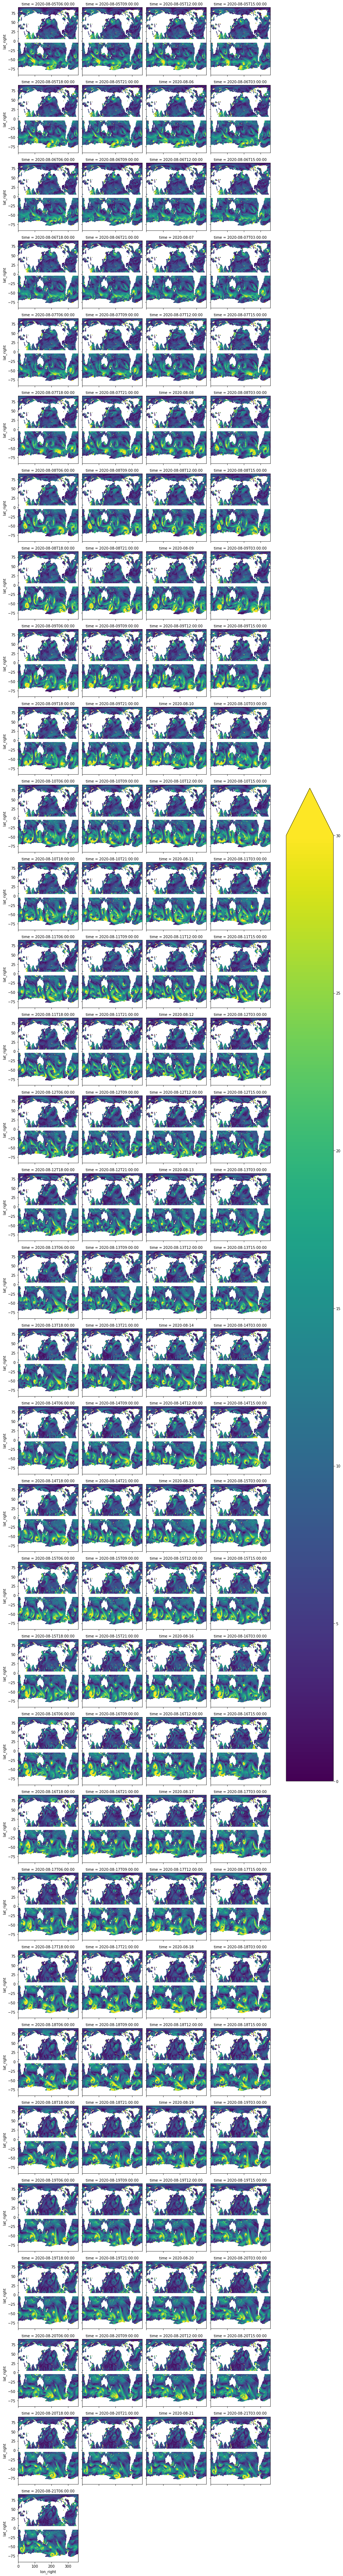

In [21]:
speed.plot(
    vmin=0, vmax=30, col="time", col_wrap=4
);